## Importing

In [1]:
from utils.utils import *
import networkx as nx
from torch_geometric.utils import from_networkx

from models.GKAN import GKAN
from models.kan.KAN import KAN
from utils.utils import fix_symbolic, automatic_fix_symbolic_kan

from models.utils.NetWrapper import NetWrapper
from train_and_eval import eval_model

import pandas as pd

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


## GKAN-ODE

We define our GKAN model as an extension of the message-passing framework in which we implement **message** and **update** functions as KANs.

- Message: $m_{j \rightarrow i} = \text{KAN}(\textbf{h}_j^{(k)}, \textbf{h}_i^{(k)})$

- Aggregation: $m_i = \sum_{j \in N(i)} m_{j \rightarrow i}$

- Update: $\textbf{h}_i^{(k+1)} = \text{KAN}(\textbf{h}_i^{(k)}, m_i)$

which can be written also as:
$$
\textbf{h}_i^{(k+1)} = H \left(\textbf{h}_i^{(k)}, \sum_j A_{ij}G(\textbf{h}_j^{(k)}, \textbf{h}_i^{(k)})\right)
$$
where functions $G$ and $H$ are KANs with parameters $\theta_G, \theta_H$, respectively.

given a node $\mathbf{x} \in \mathbb{R}^N$, our model compute its prediction in the time window $[w_0, w_n]$ as
$$ \hat{\textbf{x}}_i(w_n) = \textbf{x}_i(w_0) + \int_{w_0}^{w_n} GKAN(\textbf{x}_i(\tau), \{\textbf{x}_j(\tau)\}_{j \in N(i)_\tau}, \theta) d \tau $$

## Loss computation

Let $\mathbf{X} \in \mathbb{R}^{(W, I, N)}$ be the tensor containing training instances in the time window $W$, where

- W is the window size (i.e. the observations at different times of the dynamical process)
- I in the number of initial conditions
- N is the number of nodes

Let $\hat{\mathbf{X}} \in \mathbb{R}^{(W, I, N)}$ be the predictions of our model.

The loss can be computed in the following ways:

- $ \frac{1}{W \cdot I \cdot N} \sum_{w=1}^{W-1} \sum_{i=0}^{I-1} \sum_{n=0}^{N-1} (\hat{\mathbf{X}}[w, i, n] - \mathbf{X}[w, i, n])^2 $


- $ \frac{1}{2 \cdot I \cdot N} \sum_{i=0}^{I-1} \sum_{n=0}^{N-1} (\hat{\mathbf{X}}[1, i, n] - \mathbf{X}[1, i, n])^2 + (\hat{\mathbf{X}}[W-1, i, n] - \mathbf{X}[W-1, i, n])^2$

## Kuramoto

We want to learn symbolic representation of the Kuramoto model, described by the equation:
$$
    \frac{d x_i}{dt} = \omega_i + R \sum_j A_{ij} \text{sin}(x_j - x_i),
$$

## Utility functions

In [2]:
from torch_geometric.nn import MessagePassing
import torch

class SymbolicFakeModel(MessagePassing):
    def __init__(
        self, 
        h_symb,
        g_symb,
        aggr='add'):
      
        super(SymbolicFakeModel, self).__init__(aggr=aggr)
        
        self.h_symb = h_symb
        self.g_symb = g_symb
        
    
    def forward(self, x, edge_index):
        return self.propagate(edge_index, x=x)
    
    
    def message(self, x_i, x_j):
        out = self.g_symb(torch.cat([x_j, x_i], dim=-1))
        return out
    
    def update(self, aggr_out, x):
        out = self.h_symb(torch.cat([x, aggr_out], dim=-1))
        return out


class SymbolicWrapper(torch.nn.Module):
    def __init__(self, model, edge_index):
        super(SymbolicWrapper, self).__init__()
        self.model = model
        self.edge_index = edge_index
        
    def forward(self, t, x):
        return self.model(x, self.edge_index)

In [3]:
def fix_symbolic_kan(target_model_path, h_hidden_layers = [2, 1, 1], g_hidden_layers = [2, 1, 1]):
    model_path = "./saved_models_optuna/symb-model-two-steps"
    
    g_net = KAN(
        layers_hidden=g_hidden_layers,
        store_act=True,
        compute_symbolic=True,
        device='cpu',
    )
    
    h_net = KAN(
        layers_hidden=h_hidden_layers,
        store_act=True,
        compute_symbolic=True,
        device='cpu',
    )
    
    automatic_fix_symbolic_kan(
        layers=g_net.layers,
        symb_functions_file=f'{target_model_path}/g_net/symb_functions.json'
    )
    
    automatic_fix_symbolic_kan(
        layers=h_net.layers,
        symb_functions_file=f'{target_model_path}/h_net/symb_functions.json'
    )
    
    net = GKAN(
        h_net=h_net,
        g_net=g_net,
        device='cpu',
        model_path=model_path
    )
    
    
    return net


def get_data():
    config_path = './configs/config_kuramoto.yml'
    config = load_config(config_path)
    config['device'] = 'cpu'
    
    t_f_train = int(0.8 * config['t_eval_steps'])
    
    # G = nx.grid_2d_graph(7, 10)
    G = nx.barabasi_albert_graph(70, 3, seed=config['seed'])
    
    train_dataset, valid_data = create_datasets(config, G, t_f_train=t_f_train)
    
    edge_index = from_networkx(G).edge_index
    
    return train_dataset, valid_data, edge_index



def save_symbolic(net):
    
    train_dataset, _, edge_index = get_data()
    
    dummy_x, dummy_edge_index = sample_from_spatio_temporal_graph(train_dataset.data[0], 
                                                                  edge_index, 
                                                                  sample_size=-1)
    
    net.save_cached_data(dummy_x, dummy_edge_index)
    


def get_kan_symb_valid_loss(target_model_path, h_hidden_layers = [2, 1, 1], g_hidden_layers = [2, 1, 1]):
    training_set, valid_dataset, edge_index = get_data()
    
    net = fix_symbolic_kan(
        target_model_path=target_model_path,
        h_hidden_layers=h_hidden_layers,
        g_hidden_layers=g_hidden_layers
    )
    
    save_symbolic(net)
    
    model = NetWrapper(net, edge_index, update_grid=False)
    
    loss = eval_model(
        model,
        valid_dataset.data,
        valid_dataset.time,
        criterion=torch.nn.MSELoss(),
        t_f_train=training_set.data.size(1),
        n_iter=valid_dataset.data.size(0)
    )

    return loss


def get_symb_valid_loss(g_symb, h_symb):
    symb_model = SymbolicFakeModel(
        g_symb=g_symb,
        h_symb=h_symb
    )

    train_set, valid_set, edge_index = get_data()

    model = SymbolicWrapper(symb_model, edge_index)
    
    loss = eval_model(
        model,
        valid_set.data,
        valid_set.time,
        criterion=torch.nn.MSELoss(),
        t_f_train=train_set.data.size(1),
        n_iter=train_set.data.size(0)
    )
    
    return loss
    
    

In [4]:
model_path = './saved_models_optuna/model-kuramoto-gkan/barbasi-albert/3/eval'

Validation loss: 0.00014795214519836009

## Spline-wise symb fitting

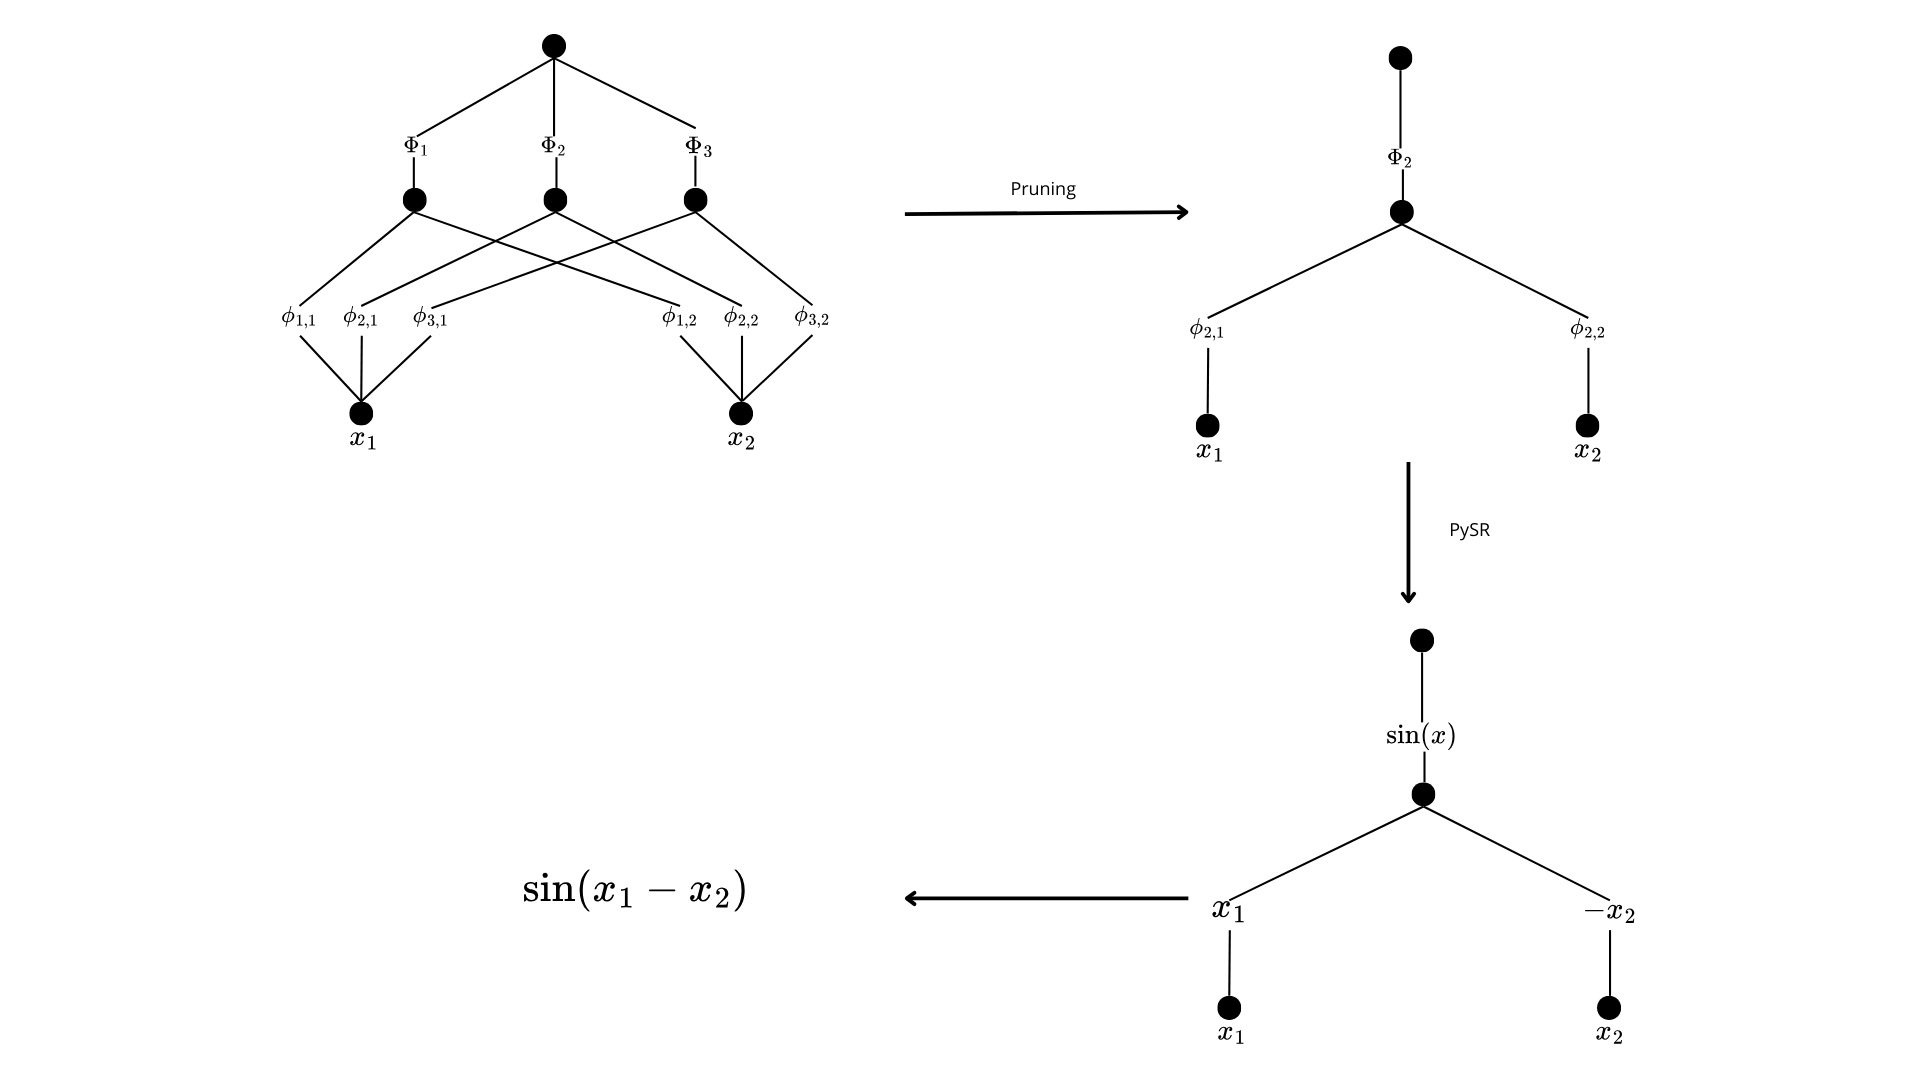

In [5]:
%matplotlib inline
from IPython.display import Image
Image('./notebooks/Spline-wise fitting.png')

In [6]:
pysr_model = lambda : get_pysr_model(
    model_selection="score"
)

symb_model = fit_model(
    n_h_hidden_layers=2,
    n_g_hidden_layers=2,
    model_path=model_path,
    theta=0.1,
    pysr_model=pysr_model,
    sample_size=2500
)

Pruning node (0,0)


/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/rcappi/.conda/envs/my_env/lib

In [7]:
sp.simplify(symb_model)

0.23939495722657*\sum_{j}( -sin(-1.00036407870052*x_i + 0.95986626525973*x_j + 0.256004693803254)) + 1.98621784202107 - 0.0403114665913038*exp(-x_i)

In [5]:
symb_valid_loss = get_kan_symb_valid_loss(
    target_model_path = model_path, 
    h_hidden_layers = [2, 1, 1], 
    g_hidden_layers = [2, 1, 1]
)

print(f"Validation loss of symbolic formula: {symb_valid_loss}")

Validation loss of symbolic formula: 0.1883630007505417


### Top 5 equations

#### G_Net

In [6]:
print("Spline (0, 0, 0)")
pd.read_csv("saved_models_optuna/model-kuramoto-gkan/barbasi-albert/3/eval/g_net/spline-wise/top_5_equations(0, 0, 0).csv")

Spline (0, 0, 0)


,Unnamed: 0,complexity,loss,score,sympy_format
0,4,5,0.000160,7.894449,2.2345679 + x0*(-1.6151466)
1,1,2,1.402717,1.849382,-x0
2,3,4,0.429535,0.646963,x0**2*(-0.21327657)
3,2,3,0.820297,0.536500,x0*(-1.1673055)
4,0,1,8.915519,0.000000,-4.50097850000000


In [7]:
print("Spline (0, 0, 1)")
pd.read_csv("saved_models_optuna/model-kuramoto-gkan/barbasi-albert/3/eval/g_net/spline-wise/top_5_equations(0, 0, 1).csv")

Spline (0, 0, 1)


,Unnamed: 0,complexity,loss,score,sympy_format
0,1,3,0.020640,2.865437,x0*1.5497605
1,2,5,0.000075,2.809547,-(-1.620619)*x0 - 0.35484058
2,3,7,0.000075,0.000003,-(-1.6206275)*(x0 - 0.13555971) - 0.13518651
3,0,1,6.361980,0.000000,x0


In [8]:
print("Spline (1, 0, 0)")
pd.read_csv("saved_models_optuna/model-kuramoto-gkan/barbasi-albert/3/eval/g_net/spline-wise/top_5_equations(1, 0, 0).csv")

Spline (1, 0, 0)


,Unnamed: 0,complexity,loss,score,sympy_format
0,3,6,0.429582,0.914729,sin(1.1280068 + x0*(-0.61936426))
1,4,7,0.182830,0.854256,tan(sin(1.126569 - 0.62103647*x0))
2,1,3,1.260328,0.172643,sin(Abs(x0))
3,2,5,1.072278,0.080793,sin(x0**2*(-0.054397393))
4,0,1,1.780080,0.000000,-0.0318239960000000


#### H_Net

In [9]:
print("Spline (0, 0, 0)")
pd.read_csv("saved_models_optuna/model-kuramoto-gkan/barbasi-albert/3/eval/h_net/spline-wise/top_5_equations(0, 0, 0).csv")

Spline (0, 0, 0)


,Unnamed: 0,complexity,loss,score,sympy_format
0,2,6,0.000162,0.297416,1.7426635 + 0.08279874/exp(x0)
1,3,7,0.000147,0.096383,1.7450327 + 0.07666039/exp(x0**2)
2,1,5,0.000218,0.082439,1.7439795 + 0.012872707/x0
3,0,1,0.000303,0.000000,1.74927950000000


In [10]:
print("Spline (0, 0, 1)")
pd.read_csv("saved_models_optuna/model-kuramoto-gkan/barbasi-albert/3/eval/h_net/spline-wise/top_5_equations(0, 0, 1).csv")

Spline (0, 0, 1)


,Unnamed: 0,complexity,loss,score,sympy_format
0,2,5,0.153742,1.510361e+00,x0*(-0.49171123) - 3.3291314
1,1,4,0.696201,3.859472e-01,-tanh(x0) - 3.328379
2,3,7,0.153742,9.756593e-08,(x0 - 1*(-6.652187))*(-0.4917136) - 1*0.058190662
3,0,1,2.216045,0.000000e+00,-3.31240530000000


In [11]:
print("Spline (1, 0, 0)")
df = pd.read_csv("saved_models_optuna/model-kuramoto-gkan/barbasi-albert/3/eval/h_net/spline-wise/top_5_equations(1, 0, 0).csv")

Spline (1, 0, 0)


In [12]:
df.head()

,Unnamed: 0,complexity,loss,score,sympy_format
0,2,5,0.039885,1.272601e+00,1.2138287 + x0*(-0.48686087)
1,1,4,0.142393,4.652734e-01,exp(tanh(-x0))
2,3,7,0.039885,6.268092e-08,x0*(-0.48686475) - 1*0.8840447 + 2.097871
3,0,1,0.575023,0.000000e+00,1.96434890000000


## Black-box fitting 

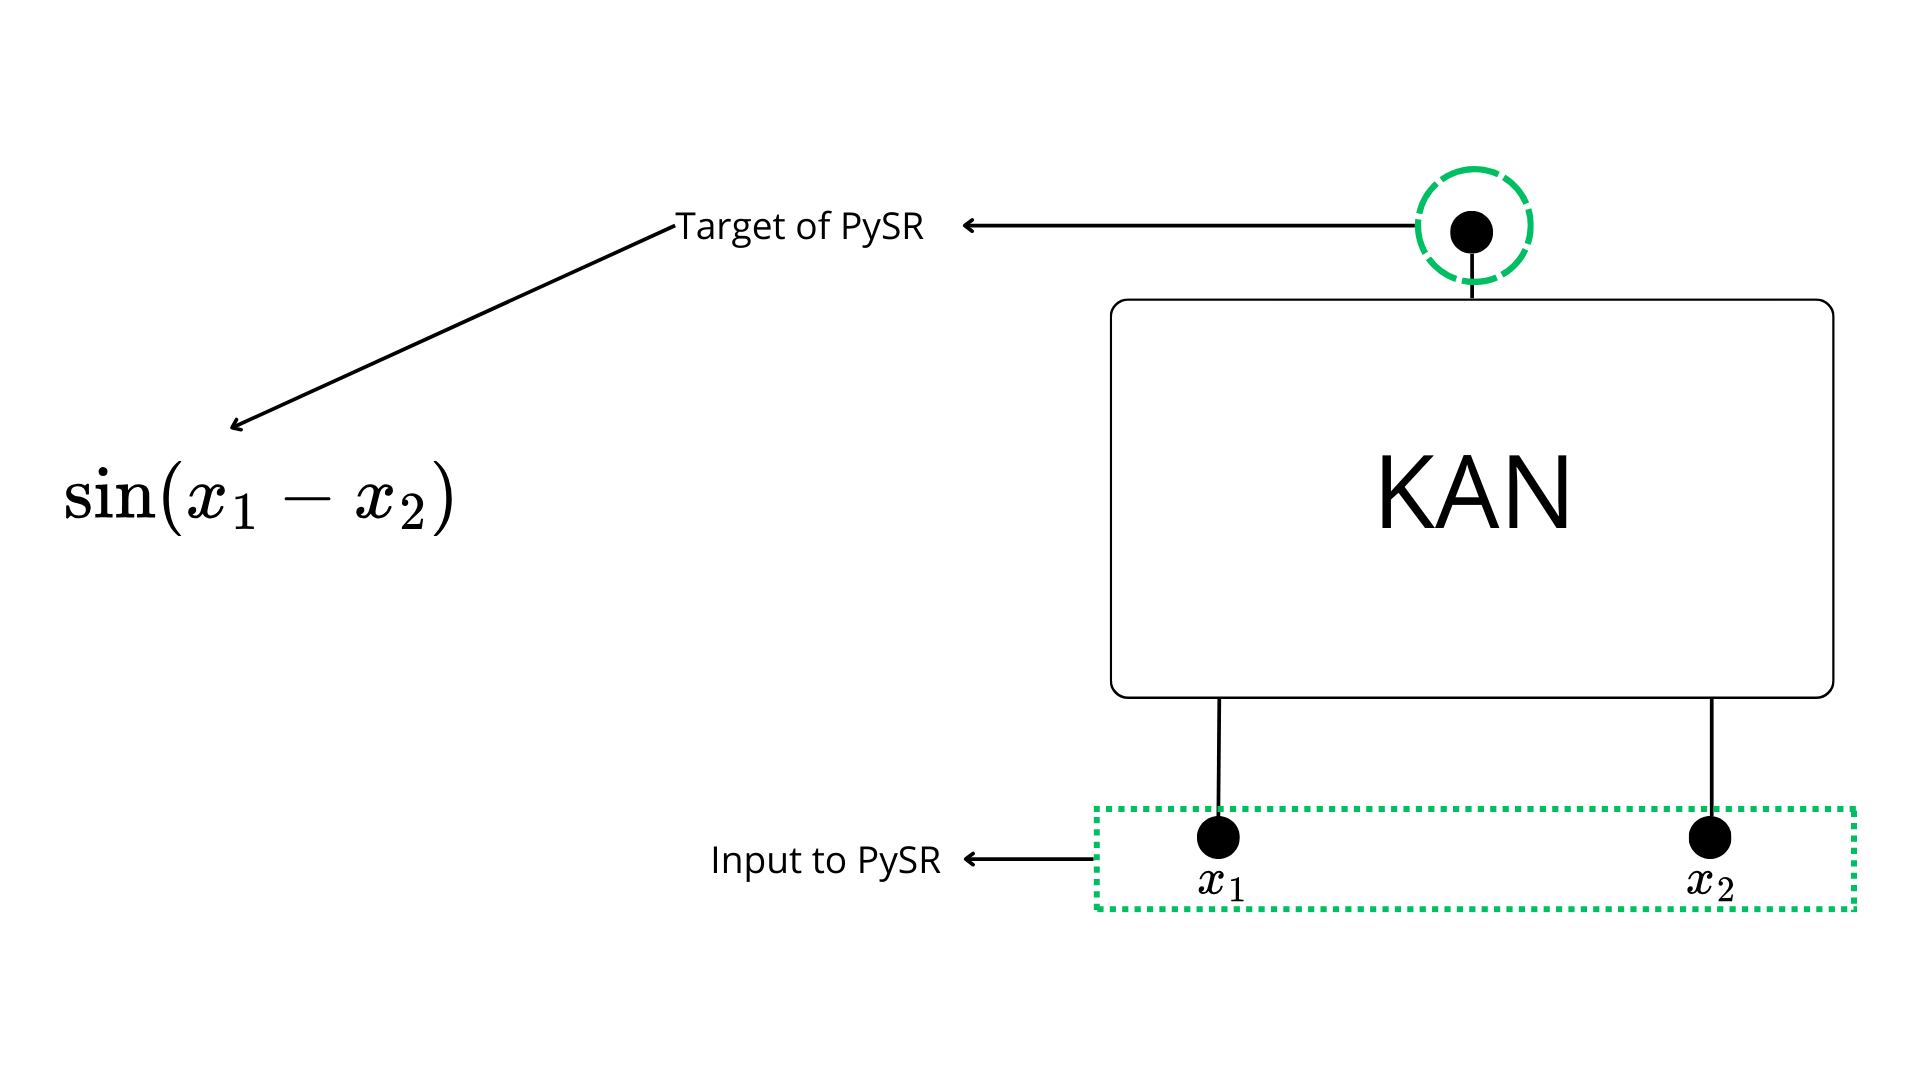

In [13]:
%matplotlib inline
from IPython.display import Image
Image('./notebooks/Symb fitting black box.png')

In [14]:
pysr_model = lambda : get_pysr_model(
    model_selection="score"
)


symb_model_black_box = fit_black_box_from_kan(
    model_path=model_path,
    n_g_hidden_layers=2,
    n_h_hidden_layers=2,
    theta=-np.inf,
    pysr_model=pysr_model,
    sample_size=2500
)

/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


In [15]:
sp.simplify(symb_model_black_box)

0.256498623474487*\sum_{j}( 1.9546822*sin(x_i - x_j)) + 1.9857075

In [16]:
g_symb_bb_kan = lambda x: (1.95302647134032 * torch.sin(x[:, 0] - x[:, 1])).unsqueeze(-1)

h_symb_bb_kan = lambda x: (0.25664377 * x[:, 1] + 1.9862221).unsqueeze(-1)

print(f" Validation loss of black-box symbolic model: {get_symb_valid_loss(g_symb=g_symb_bb_kan, h_symb=h_symb_bb_kan)}")

 Validation loss of black-box symbolic model: 0.00015706288104411215


### Top 5 equations

#### G_Net

In [17]:
pd.read_csv("saved_models_optuna/model-kuramoto-gkan/barbasi-albert/3/eval/black-box/top_5_equations_g.csv")

,Unnamed: 0,complexity,loss,score,sympy_format
0,4,6,0.008081,3.138584,sin(x0 - x1)*1.9546822
1,2,4,0.431003,1.405576,sin(x0 - x1)
2,3,5,0.186439,0.838008,tan(sin(x0 - x1))
3,1,3,1.757575,0.006620,exp(-x0)
4,0,1,1.781001,0.000000,-0.00468803900000000


#### H_Net

In [18]:
pd.read_csv("saved_models_optuna/model-kuramoto-gkan/barbasi-albert/3/eval/black-box/top_5_equations_h.csv")

,Unnamed: 0,complexity,loss,score,sympy_format
0,2,5,0.000736,5.612687e+00,x1/3.8986564 - 1*(-1.9857075)
1,1,4,0.201541,3.663734e-01,exp(tanh(exp(x1)))
2,3,7,0.000736,2.310177e-07,x1/3.898687 - 1*(-0.52258795) + 1.4631194
3,0,1,0.604930,0.000000e+00,1.98299620000000


## PySR baseline 

In [7]:
def create_xy_from_time_series(data, batch_size=32, deriv=False):
    data = data.cpu().detach().numpy()
    ic_s, time_steps, n_nodes, _ = data.shape
    
    X, y = [], []
    time_batches = np.arange(0, time_steps-1, step=batch_size)
    
    for i in range(ic_s):
        data_i = data[i]
        for t in time_batches:
            if deriv:
                X.append(np.repeat([t], repeats=n_nodes, axis=0))
                y.append(data_i[t, :, :])
            else:
                X.append(data_i[t, :, :]) # x_t
                y.append(data_i[t+1, :, :]) # x_{t+1}
            
    X = np.concatenate(X, axis=0)
    y = np.concatenate(y, axis=0)
    
    return X, y

def pysr_baseline(train_dataset):
    X_train, y_train = create_xy_from_time_series(train_dataset.data)
    model = get_pysr_model()
    model.fit(X_train, y_train)
    symb_model = model.sympy()
    print(sp.simplify(symb_model))

In [8]:
config_path = './configs/config_kuramoto.yml'
config = load_config(config_path)
config['device'] = 'cpu'

t_f_train = int(0.8 * config['t_eval_steps'])
G = nx.grid_2d_graph(7, 10)

train_dataset, _ = create_datasets(config, G, t_f_train=t_f_train)

pysr_baseline(train_dataset)

/home/rcappi/Kan-for-Graph-Dyn/.venv/gkanconv-ode/lib/python3.9/site-packages/pysr/sr.py:2582: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Abs(x0 + 0.00668541230924163)


Abs(x0 + 0.00668541230924163)

## MPNN symb fitting

Validation loss: 0.00044558296212926507

In [22]:
pysr_model = lambda : get_pysr_model(
    batching=True,
    batch_size=512,
    model_selection="score"
)

symb_mpnn = fit_mpnn(
    model_path='./saved_models_optuna/model-kuramoto-mpnn/barbasi-albert-mpnn/2/eval',
    pysr_model=pysr_model
)

/home/rcappi/Kan-for-Graph-Dyn/.venv/gkanconv-ode/lib/python3.9/site-packages/pysr/sr.py:2582: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/rcappi/Kan-for-Graph-Dyn/.venv/gkanconv-ode/lib/python3.9/site-packages/pysr/sr.py:2582: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


In [23]:
symb_mpnn

1.9861443 - 0.423580022102406*\sum_{j}( -sin(x_i - x_j))

In [24]:
g_symb_bb_mpnn = lambda x: (-torch.sin(x[:, 0] - x[:, 1])).unsqueeze(-1)

h_symb_bb_mpnn = lambda x: (-0.4236273 * x[:, 1] + 1.9857944).unsqueeze(-1)

print(f"Validation loss of black-box model: {get_symb_valid_loss(g_symb=g_symb_bb_mpnn, h_symb=h_symb_bb_mpnn)}")

Validation loss of black-box model: 0.011060720309615135


### Top 5 equations

#### G_Net

In [25]:
pd.read_csv("saved_models_optuna/model-kuramoto-mpnn/barbasi-albert-mpnn/2/eval/top_5_equations_g.csv")

,Unnamed: 0,complexity,loss,score,equation,sympy_format,lambda_format
0,2,4,0.012487,3.860966,sin(x1 - x0),sin(-x0 + x1),PySRFunction(X=>sin(-x0 + x1))
1,3,6,0.002161,0.877002,sin(x1 - x0) / 0.8687563,sin(-x0 + x1)/0.8687563,PySRFunction(X=>sin(-x0 + x1)/0.8687563)
2,1,3,0.593250,0.006596,exp(neg(x1)),exp(-x1),PySRFunction(X=>exp(-x1))
3,0,1,0.601128,0.000000,0.022401383,0.0224013830000000,PySRFunction(X=>0.0224013830000000)


#### H_Net

In [26]:
pd.read_csv("saved_models_optuna/model-kuramoto-mpnn/barbasi-albert-mpnn/2/eval/top_5_equations_h.csv")

,Unnamed: 0,complexity,loss,score,equation,sympy_format,lambda_format
0,2,5,0.000800,5.335361,1.9861443 - (x1 / 2.360829),1.9861443 - x1/2.360829,PySRFunction(X=>1.9861443 - x1/2.360829)
1,1,4,0.166034,0.443357,1.9803509 - tanh(x1),1.9803509 - tanh(x1),PySRFunction(X=>1.9803509 - tanh(x1))
2,0,1,0.627828,0.000000,1.9317006,1.93170060000000,PySRFunction(X=>1.93170060000000)


## Validation loss lower bound

In [5]:
g_symb = lambda x: torch.sin(x[:, 0] - x[:, 1]).unsqueeze(-1)

h_symb = lambda x: 2.0 + 0.5*x[:, 1].unsqueeze(-1)

print(get_symb_valid_loss(g_symb=g_symb, h_symb=h_symb))


8.553109296371986e-07


## Two steps symb fitting

In [6]:
from pysr import TemplateExpressionSpec

In [7]:
def two_steps_fitting(model_path, pysr_model, sample_size=-1, theta=0.1):
    cache_acts, cache_preacts = get_kan_arch(n_layers=2, model_path=model_path)
    pruned_acts, pruned_preacts = pruning(cache_acts, cache_preacts, theta=theta)

    input = pruned_preacts[0]
    output = pruned_acts[-1].sum(dim=2)

    in_dim = input.size(1)
    out_dim = output.size(1)

    x = input.detach().numpy().reshape(-1, in_dim)
    y = output.detach().numpy().reshape(-1, out_dim)

    return fit_acts_pysr(x, y, pysr_model, sample_size=sample_size)

### G_Net

In [8]:
template = TemplateExpressionSpec(
    expressions = ["sp0", "sp1", "sp2", "f"],
    variable_names = ["x0", "x1"],
    combine="""
        y0 = sp0(
            2.2345679 + x0*(-1.6151466), 
            -x0, 
            x0^2*(-0.21327657), 
            x0*(-1.1673055), 
            -4.50097850000000 + x0 * 0
        )
        
        y1 = sp1(
            x1*1.5497605, 
            -(-1.620619)*x1 - 0.35484058, 
            -(-1.6206275)*(x1 - 0.13555971) - 0.13518651, 
            x1
        )
        
        l1 = y0 + y1

        kan = sp2(
            sin(1.1280068 + l1*(-0.61936426)), 
            tan(sin(1.126569 - 0.62103647*l1)),
            sin(abs(l1)), 
            sin(l1^2*(-0.054397393)), 
            -0.0318239960000000 + l1 * 0,
        )

        f(x0, x1, kan)
    """
)

pysr_model = lambda : get_pysr_model(
    model_selection="score",
    precision=64,
    expression_spec = template,
    n_iterations=50
)

In [9]:
top_5_eq = two_steps_fitting(
    model_path = f"{model_path}/g_net",
    pysr_model = pysr_model,
    sample_size = 2000,
    theta=-np.inf
)

/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


In [10]:
top_5_eq

,complexity,loss,equation,score,julia_expression,lambda_format
1,6,0.003781,sp0 = #1; sp1 = #2; sp2 = #1 / 0.5117462544694...,1.928528,sp0 = #1; sp1 = #2; sp2 = #1 / 0.5117462544694...,<pysr.expression_specs.CallableJuliaExpression...
2,7,0.003780,sp0 = #1; sp1 = abs(#2); sp2 = #1 / 0.51173203...,0.000134,sp0 = #1; sp1 = abs(#2); sp2 = #1 / 0.51173203...,<pysr.expression_specs.CallableJuliaExpression...
0,4,0.178916,sp0 = #1; sp1 = #2; sp2 = #2; f = #3,0.000000,sp0 = #1; sp1 = #2; sp2 = #2; f = #3,<pysr.expression_specs.CallableJuliaExpression...


In [11]:
top_5_eq.iloc[0]['equation']

'sp0 = #1; sp1 = #2; sp2 = #1 / 0.5117462544694338; f = #3'

In [17]:
from sympy import *

In [13]:
x0, x1 = sp.symbols('x0 x1')

y0 = sp.simplify(2.2345679 + x0*(-1.6151466))
y1 = sp.simplify(-(-1.620619)*x1 - 0.35484058)
l1 = y0 + y1

kan = sp.simplify(sin(1.1280068 + l1*(-0.61936426)) / 0.5117462544694338)

symb = kan

symb

-1.95409344233848*sin(-1.00036407870052*x0 + 1.00375348767694*x1 + 0.0362291205535832)

### H_Net

In [17]:
template = TemplateExpressionSpec(
    expressions = ["sp0", "sp1", "sp2", "f"],
    variable_names = ["x0", "x1"],
    combine="""
        y0 = sp0(
          1.7426635 + 0.08279874/exp(x0), 
          1.7450327 + 0.07666039/exp(x0^2),
          1.7439795 + 0.012872707/x0,
          1.74927950000000 + x0 * 0
        )
        
        y1 = sp1(
          x1*(-0.49171123) - 3.3291314,
          -tanh(x1) - 3.328379,
          (x1 - 1*(-6.652187))*(-0.4917136) - 1*0.058190662, 
          -3.31240530000000 + x1 * 0
        )
        
        l1 = y0 + y1

        kan = sp2(
          1.2138287 + l1*(-0.48686087), 
          exp(tanh(-l1)),
          l1*(-0.48686475) - 2.9819157, 
          1.96434890000000 + l1 * 0
        )

        f(x0, x1, kan)
    """
)

pysr_model = lambda : get_pysr_model(
    model_selection="score",
    precision=64,
    expression_spec = template,
    n_iterations=50
)

In [18]:
top_5_eq = two_steps_fitting(
    model_path = f'{model_path}/h_net',
    pysr_model = pysr_model,
    sample_size = 2000,
    theta=-np.inf
)

/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


In [19]:
top_5_eq

,complexity,loss,equation,score,julia_expression,lambda_format
1,6,0.000650,sp0 = 1.9918875044001518; sp1 = #3 * 1.0746858...,0.801675,sp0 = 1.9918875044001518; sp1 = #3 * 1.0746858...,<pysr.expression_specs.CallableJuliaExpression...
0,4,0.003229,sp0 = #2; sp1 = #3; sp2 = #1; f = #3,0.000000,sp0 = #2; sp1 = #3; sp2 = #1; f = #3,<pysr.expression_specs.CallableJuliaExpression...


In [20]:
top_5_eq.iloc[0]['equation']

'sp0 = 1.9918875044001518; sp1 = #3 * 1.074685803042384; sp2 = #1; f = #3'

In [23]:
symb_g =  sp.Symbol(r'\sum_{j}' + str(symb))

y0 = 1.9918875044001518
y1 = sp.simplify(((symb_g - 1*(-6.652187))*(-0.4917136) - 1*0.058190662) * 1.074685803042384)

l1 = y0 + y1

kan = sp.simplify(1.2138287 + l1*(-0.48686087))

symb_h = kan

symb_h

0.257275601888576*\sum_{j}-1.95409344233848*sin(-1.00036407870052*x0 + 1.00375348767694*x1 + 0.0362291205535832) + 1.98594869258026

TODO: Calcolare la loss

## IC = 1

In [2]:
model_path_ic1 = './saved_models_optuna/model-kuramoto-gkan/barabasi-albert-ic1/2/eval'

In [3]:
pysr_model = lambda : get_pysr_model(
    model_selection="score"
)

symb_model = fit_model(
    n_h_hidden_layers=2,
    n_g_hidden_layers=2,
    model_path=model_path_ic1,
    theta=0.1,
    pysr_model=pysr_model,
    sample_size=2500
)

Pruning node (0,1)


/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/rcappi/.conda/envs/my_env/lib

In [4]:
sp.simplify(symb_model)

0.383949426507205*(-0.0937474272632141*\sum_{j}( sin(-x_i + Abs(x_j - 2.3984098) + 2.546883)) + 0.599798440974292*tanh(x_i - 1.7176079) + 1)**3 + tan(sin(0.203663058880884*\sum_{j}( sin(-x_i + Abs(x_j - 2.3984098) + 2.546883)) + 2.72102521170864 - 3.98574029432203*exp(-x_i)))

### Black box fitting

In [5]:
pysr_model = lambda : get_pysr_model(
    model_selection="score"
)


symb_model_black_box = fit_black_box_from_kan(
    model_path=model_path_ic1,
    n_g_hidden_layers=2,
    n_h_hidden_layers=2,
    theta=-np.inf,
    pysr_model=pysr_model,
    sample_size=2500
)

/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


In [6]:
sp.simplify(symb_model_black_box)

-0.093395285*\sum_{j}( -sin(x_i - x_j))*x_i + 1.8489553

## Epidemics

In [4]:
model_path = './saved_models_optuna/model-epidemics-gkan/epidemics-fixed-3/1/gkan'

In [15]:
pysr_model = lambda : get_pysr_model(
    model_selection="score"
)

symb_model_black_box = fit_black_box_from_kan(
    model_path=model_path,
    n_g_hidden_layers=2,
    n_h_hidden_layers=2,
    theta=-np.inf,
    pysr_model=pysr_model,
    sample_size=7000,
    message_passing=False
)

/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


In [16]:
symb_model_black_box

\sum_{j}( x_i*(0.50289035 - 0.5045943*x_j)) - 0.49474376*x_i

## Spline-wise

In [5]:
pysr_model = lambda : get_pysr_model(
    model_selection="score"
)

symb_model = fit_model(
    n_h_hidden_layers=2,
    n_g_hidden_layers=2,
    model_path=model_path,
    theta=0.01,
    pysr_model=pysr_model,
    sample_size=7000,
    message_passing=False
)

/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/rcappi/.conda/envs/my_env/lib

In [6]:
symb_model

\sum_{j}( -0.26952615*(x_j - 0.27433524)**3 + (0.5149971*x_i - log(x_j + 1) + 0.4566862)**3 + 0.0276228898794936*sin(2.210681*x_i) + 0.062099602) + log(1 - 0.345992231851609*x_i) - 0.066259734

## Two steps

### G_Net

In [27]:
julia_code = """
    y0 = sp0(
        x0*0.38165793,
        tan(x0*0.37040955),
        0.269087760000000 + x0*0
    )
    
    y1 = sp1(
        tan(x1)*(-0.10868067),
        (x1 + x1)*(-0.071464434),
        -0.101634960000000 + x1*0
    )
    n0 = y0 + y1
    
    
    y2 = sp2(
        0.00758783071915381 + x0*0,
        0.00545692074538671 + x0*0,
        0.0586319160000000 + x0*0
    )
    
    y3 = sp3(
        x1*(x1^3 - x1),
        (x1^9 - x1)*0.3977244,
        x1*(x1 - 1.0819764),
        -0.215150550000000 + x1*0
    )
    n1 = y2 + y3
    
    y4 = sp4(
        x0/18.808764,
        0.08034914*abs(tanh(x0 - 0.22721611)),
        0.0362873520000000 + x0*0
    )
    
    y5 = sp5(
        tan(x1*(-0.35263544)),
        tan(tan(x1*(-0.56243384)))*0.547288,
        -0.257088000000000 + x1*0
    )
    n2 = y4 + y5
    
    
    y6 = sp6(
        n0*(-0.1515363),
        0 + n0 * 0,
        -0.732307140000000 + n0*0
    )
    
    y7 = sp7(
        -0.0192912970000000 + n1*0
    )
    
    y8 = sp8(
        abs(n2 - tanh(n2)),
        0 - 1*(-0.0028113788) + n2*0,
        0.0 + n2*0
    )
    
    
    kan = y6 + y7 + y8
    
    f(x0, x1, kan)
"""

template = TemplateExpressionSpec(
    expressions = ["sp0", "sp1", "sp2", "sp3", "sp4", "sp5", "sp6", "sp7", "sp8", "f"],
    variable_names = ["x0", "x1"],
    combine=julia_code
)

pysr_model = lambda : get_pysr_model(
    model_selection="score",
    precision=64,
    expression_spec = template,
    n_iterations=100
)

In [28]:
top_5_eq = two_steps_fitting(
    model_path = f"{model_path}/g_net",
    pysr_model = pysr_model,
    sample_size = 2500,
    theta=-np.inf
)

/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


In [29]:
top_5_eq

,complexity,loss,equation,score,julia_expression,lambda_format


In [18]:
x0, x1 = sp.symbols('x0 x1')

y0 = -0.02432663400802618
y1 = sp.simplify( sin(x1**3/(-0.6586664))**3)
n0 = y0 + y1

y2 = sp.simplify(sin(tan(0.033712227 - x0)*0.6257177))
y3 = sp.simplify(x1*sin(0.9220614 - x1))
n1 = y2 + y3

y4 = sp.simplify((0.1494056*n0 - 1*0)**2)
y5 = sp.simplify(tan(tanh(0.16927527 - n1)*(-0.14635544)))

kan = y4 + y5
kan_g = kan

kan_g

0.02232203331136*(sin(1.51821923814544*x1**3)**3 + 0.0243266340080262)**2 - tan(0.14635544*tanh(x1*sin(x1 - 0.9220614) + sin(0.6257177*tan(x0 - 0.033712227)) + 0.16927527))